#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, activation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

##Imports and Install

In [ ]:
! pip install ray torch torchvision ax-platform sqlalchemy

     |████████████████████████████████| 23.1MB 1.7MB/s 
     |████████████████████████████████| 501kB 41.9MB/s 
     |████████████████████████████████| 2.9MB 43.4MB/s 
     |████████████████████████████████| 1.3MB 42.3MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 204kB 54.4MB/s 
     |████████████████████████████████| 133kB 47.6MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 225kB 48.8MB/s 
     |████████████████████████████████| 143kB 53.1MB/s 
     |████████████████████████████████| 296kB 51.3MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 286kB 48.6MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=f0aa3a4e2eb0a78c1777c7aa491982025e9b5f34dae973962414fec5336461df
  Stored in dir

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from ray import tune
from ray.tune.suggest.ax import AxSearch
from PIL import Image

## Dataset

Defining custom Dataset:

In [ ]:
class ClassificationDataset(Dataset):

  def __init__(self, dataset, transform=None):
    self.transform = transform
    self.data = []

    for sample in dataset:
      self.data.append(sample)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx][0]
    label = self.data[idx][1]
    if self.transform:
      image = self.transform(image)
      
    return (image, label)

Download the dataset and define transformations:

In [ ]:
transform_train = transforms.Compose([transforms.RandomAffine(degrees=20, translate=(0.05, 0.05), scale=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                      ])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                     ])


train_dataset_original = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=None)
test_dataset_original  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=None)

## To calculate the value for mean and standard devation of the training dataset
#loader = DataLoader(train_dataset_original, batch_size=len(train_dataset_original), num_workers=1)
#data = next(iter(loader))
#data[0].mean(), data[0].std()

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw



Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



Define the custom dataset and splitting the train and validation dataset:

In [ ]:
train_dataset_complete = ClassificationDataset(train_dataset_original, transform_train)
test_dataset = ClassificationDataset(test_dataset_original, transform_test)

train_dataset, val_dataset = train_test_split(train_dataset_original, test_size=0.20, random_state=0)
train_dataset = ClassificationDataset(train_dataset, transform_train)
val_dataset = ClassificationDataset(val_dataset, transform_test)

You can see that running the code several times the image remains the same but it is transformed:

SAMPLE AT INDEX 0
LABEL: 7


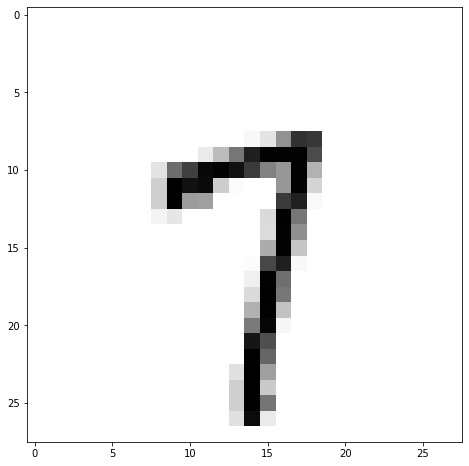

In [ ]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image[0], cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

##Network Definition

###Basic Network

In [ ]:
class Net(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.fc1 = nn.Linear(in_features=784, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=64)
    self.out = nn.Linear(in_features=64, out_features=10)
    self.act = nn.ReLU()

    print('Network initialized')

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)
    
    return x

###Convolutional Network

In [ ]:
class Net(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.cnn_model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1),  # (N, 1, 28, 28)  -> (N, 10, 24, 24)
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),                               # (N, 10, 24, 24) -> (N, 10, 12, 12)
      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1), # (N, 10, 12, 12) -> (N, 20, 8, 8)
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2)                                # (N, 20, 8, 8)   -> (N, 20, 4, 4)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(in_features=320, out_features=160),                      # (N, 320)        -> (N, 160)
        nn.ReLU(),
        nn.Linear(in_features=160, out_features=10),                       # (N, 160)        -> (N, 10)
        nn.ReLU()
    )

    print('Network initialized')

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x

In [ ]:
class Net(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)  # (N, 1, 28, 28)  -> (N, 10, 24, 24)
    self.avgpool_1 = nn.AvgPool2d(kernel_size=2, stride=2)                           # (N, 10, 24, 24) -> (N, 10, 12, 12)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1) # (N, 10, 12, 12) -> (N, 20, 8, 8)
    self.avgpool_2 = nn.AvgPool2d(kernel_size=2, stride=2)                           # (N, 20, 8, 8)   -> (N, 20, 4, 4)
    self.relu = nn.ReLU()

    self.fc_model = nn.Sequential(
        nn.Linear(in_features=320, out_features=160),                      # (N, 320)        -> (N, 160)
        nn.ReLU(),
        nn.Linear(in_features=160, out_features=10),                       # (N, 160)        -> (N, 10)
        nn.ReLU()
    )

    print('Network initialized')

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.avgpool_1(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.avgpool_2(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x

##Training

In [ ]:
# Checking device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

# Setting manual seed
torch.manual_seed(0)

Training device: cuda
Tue Dec  8 13:28:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                  

In [ ]:
cnn = True
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

optimization = True

def train(config): 
  if optimization:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)
  else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset_complete, batch_size=config['train_batch_size'], shuffle=True)
  
  net = Net(config)
  net.to(device)

  # Define the loss function
  loss_fn = nn.CrossEntropyLoss()

  # Define the optimizer
  optimizer = optim.SGD(net.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])

  epochs = 100
  train_loss_log = []
  val_acc_log = []

  for epoch in range(epochs):
    if not optimization:
      #print('#################')
      print(f'# EPOCH {epoch}/{epochs}')
      #print('#################')

    ### TRAIN
    train_loss = []
    net.train()

    for images_batch, labels_batch in train_dataloader:
      # Move data to device
      images_batch = images_batch.to(device)
      labels_batch = labels_batch.to(device)
      
      # Flatening the images (activate only for basic network, not for CNN)
      if not cnn:
        images_batch = images_batch.view(images_batch.shape[0], -1)

      # Forward pass
      out = net(images_batch)

      # Compute loss
      loss = loss_fn(out, labels_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      #Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    if optimization:
      ### VALIDATION
      correct_count, all_count = 0, 0
      net.eval()

      with torch.no_grad():
        for images_batch, labels_batch in val_dataloader:
          # Move data to device
          images_batch = images_batch.to(device)
          labels_batch = labels_batch.to(device)

          # Flatening the images (activate only for basic network, not for CNN)
          if not cnn:
            images_batch = images_batch.view(images_batch.shape[0], -1)

          # Forward pass
          out = net(images_batch)

          # Calculating right preditions 
          for idx, logps in enumerate(out):
            ps = torch.exp(logps)
            probab = list(ps.cpu().numpy())
            pred_label = probab.index(max(probab))
            true_label = labels_batch[idx].cpu()
            
            if true_label == pred_label:
              correct_count += 1
            all_count += 1

      # Save validation accuracy
      val_acc = correct_count / all_count
      #print(f"VAL ACCURACY: {val_acc}")
      val_acc_log.append(val_acc)

    if optimization:
      # Send the current training result back to Tune
      tune.report(val_acc=val_acc, train_loss=train_loss)

  # Saving the model
  model_name = f'model_lr={config["lr"]}-momentum={config["momentum"]}-weight_decay={config["weight_decay"]}-train_batch_size={config["train_batch_size"]}'
  torch.save(net.state_dict(), f'/content/{model_name}.pth')

  if not optimization:
    return net

def test(net):
  correct_count, all_count = 0, 0
  net.eval()

  with torch.no_grad():
    for images_batch, labels_batch in test_dataloader:
      # Move data to device
      images_batch = images_batch.to(device)
      labels_batch = labels_batch.to(device)

      # Flatening the images (activate only for basic network, not for CNN)
      if not cnn:
       images_batch = images_batch.view(images_batch.shape[0], -1)

      # Forward pass
      out = net(images_batch)

      # Calculating right preditions 
      for idx, logps in enumerate(out):
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy())
        pred_label = probab.index(max(probab))
        true_label = labels_batch[idx].cpu()
        
        if true_label == pred_label:
          correct_count += 1
        all_count += 1

  # Save test accuracy
  test_acc = correct_count / all_count
  print(f"TEST ACCURACY: {test_acc}")

###Hyper-parameters tuning

In [ ]:
## Used to find optimal hyper-parameters
search_space = {
    'lr': tune.uniform(0.0001, 0.01),
    'momentum': tune.uniform(0, 1),
    'weight_decay': tune.uniform(0, 0.1),
    'train_batch_size': tune.randint(4, 400)
}

## First parameters found optimal
search_space = {
    'lr': 0.00609546882016259,
    'momentum': 0.4665301409295612,
    'weight_decay': 9.876754276014444e-05,
    'train_batch_size': 7
}

## Final parameters found optimal
search_space = {
    'lr': 0.0076909336118989105,
    'momentum': 0.6096049329165835,
    'weight_decay': 1.320447863976398e-18,
    'train_batch_size': 4
}

#Running in optimization mode
optimization = True

ax_search = AxSearch(metric="val_acc", mode='max')
analysis = tune.run(
    run_or_experiment=train,
    config=search_space,
    search_alg=ax_search,
    resources_per_trial={'gpu': 1}, 
    num_samples=1,
    metric='val_acc',
    mode='max',
    verbose=1
)

2020-12-07 13:51:56,126	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-07 13:51:58,967	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
[INFO 12-07 13:52:02] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 12-07 13:52:02] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
2020-12-07 13:52:02,865	WARNING ax.py:177 -- Detected sequential enforcement. Be sure to use a ConcurrencyLimiter

KeyboardInterrupt: ignored

###Loading the best model

In [ ]:
config = {
    'lr': 0.0076909336118989105,
    'momentum': 0.6096049329165835,
    'weight_decay': 1.320447863976398e-18,
    'train_batch_size': 4
}

net = Net(config)
net.to(device) 

model_file_name = f'model_lr={config["lr"]}-momentum={config["momentum"]}-weight_decay={config["weight_decay"]}-train_batch_size={config["train_batch_size"]}.pth'
net.load_state_dict(torch.load(model_file_name))

Network initialized


<All keys matched successfully>

BEST: train_705ac252: {'lr': 0.0076909336118989105, 'momentum': 0.6096049329165835, 'weight_decay': 1.320447863976398e-18, 'train_batch_size': 4}



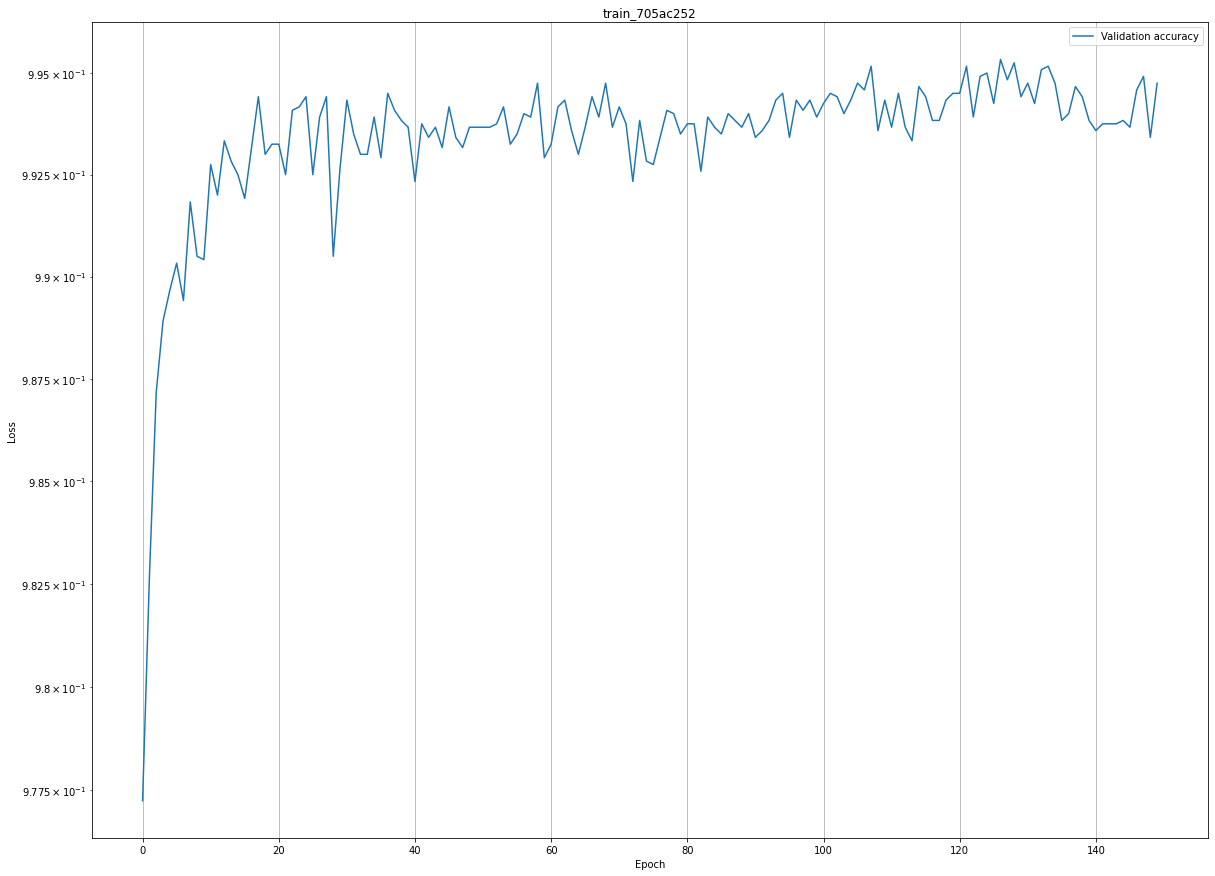

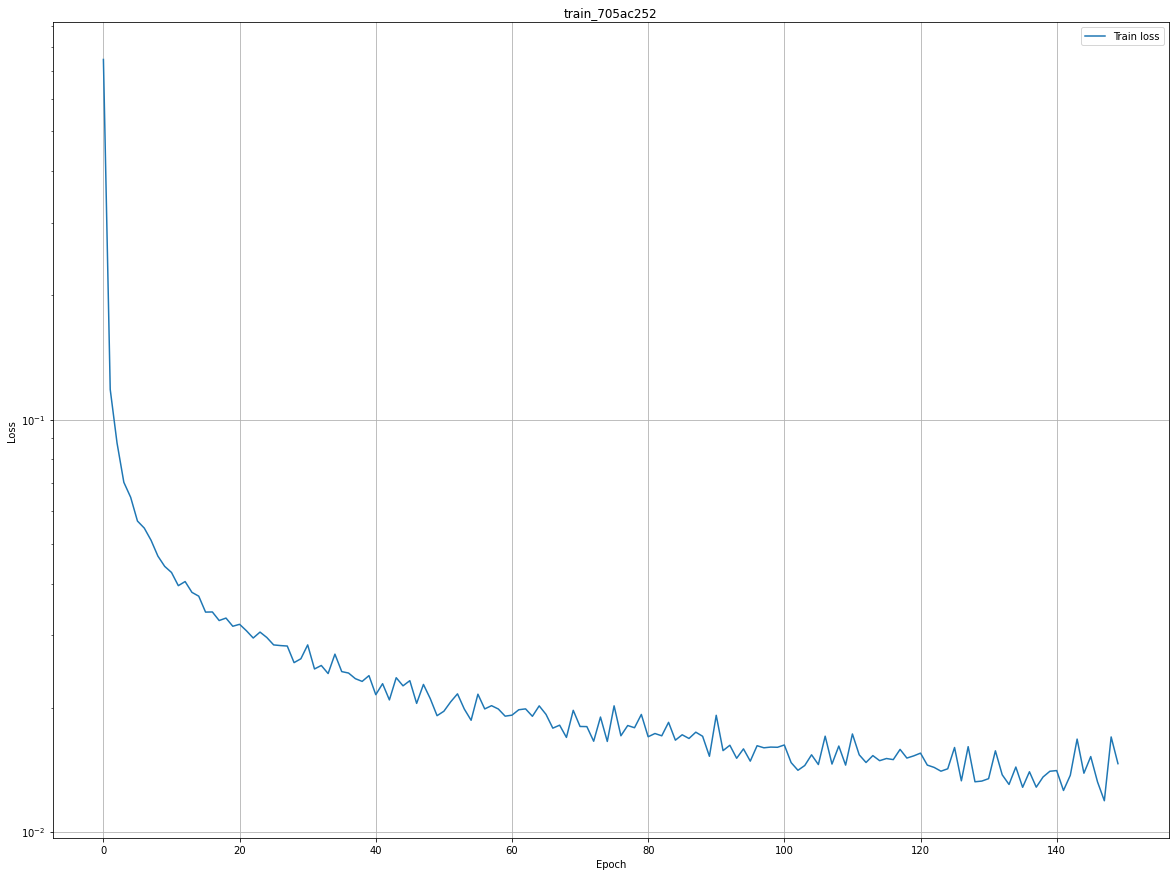

In [ ]:
dfs = analysis.trial_dataframes
print(f'BEST: {analysis.best_trial}: {analysis.best_trial.config}\n')

for index, d in enumerate(dfs.values()):
  plt.figure(figsize=(20,15))
  plt.title(f'{analysis.trials[index]}')
  plt.semilogy(d.val_acc, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

for index, d in enumerate(dfs.values()):
  plt.figure(figsize=(20,15))
  plt.title(f'{analysis.trials[index]}')
  plt.semilogy(d.train_loss, label='Train loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
test(net)

TEST ACCURACY: 0.9944


###Training on the all training dataset and testing the final model on the test set

In [ ]:
optimization = False

net = train(config)
test(net)

##Network analysis

###Visualizing Convolutional Layer Filters

In [ ]:
print(net)

Net(
  (cnn_model): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=320, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=10, bias=True)
    (3): ReLU()
  )
)


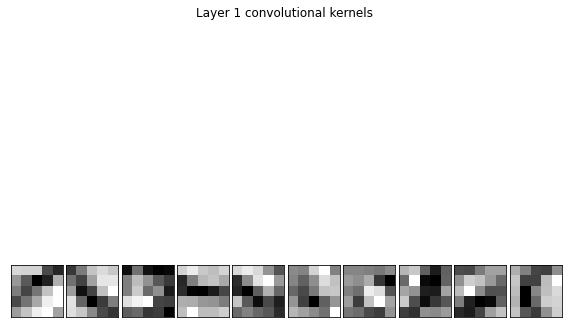

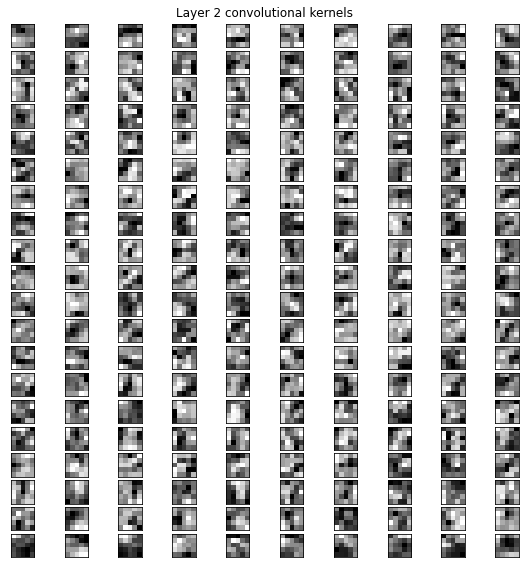

In [ ]:
### Extract weights 
# Layer 1 weights
weights_l1 = net.cnn_model[0].weight.data.cpu().numpy()
# Layer 2 weights
weights_l2 = net.cnn_model[3].weight.data.cpu().numpy()

### Plot the weights (this is a utility function, no need to analyze this code)
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(weights_l1, 1, 10, 'Layer 1 convolutional kernels')
plot_nchw_data(weights_l2, 20, 10, 'Layer 2 convolutional kernels')

###Setting hooks

In [ ]:
def get_activation_1(layer, input, output):
    global activation_1
    activation_1 = torch.relu(output)

def get_activation_2(layer, input, output):
    global activation_2
    activation_2 = torch.relu(output)

hook_handle_1 = net.conv1.register_forward_hook(get_activation_1)
hook_handle_2 = net.conv2.register_forward_hook(get_activation_2)

###Trying the final model on a random sample and visualizing

In [ ]:
def predict(dataset, index=None):
  if index is None:
    index = np.random.randint(0, len(dataset))

  image = dataset[index][0]
  label = dataset[index][1]
  pred_label = None

  tensor_to_pil_image = transforms.ToPILImage(mode='L')
  image_pil = tensor_to_pil_image(image.squeeze())

  net.eval()
  with torch.no_grad():
    # Move data to device
    image = image.to(device)

    # Adding batch dimension
    image = image.unsqueeze(0)

    # Forward pass
    out = net(image)

    # Evaluating the prediction
    ps = torch.exp(out)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))

  print(f'SAMPLE AT INDEX {index}')
  print(f'TRUE LABEL: {label}')
  print(f'PREDICTED LABEL: {pred_label}')

  if label == pred_label:
    print('\n--- CORRECT ---\n')
  else:
    print('\n--- WRONG ---\n')

  fig = plt.figure(figsize=(8,8))
  plt.imshow(image_pil, cmap='Greys')

SAMPLE AT INDEX 2144
TRUE LABEL: 6
PREDICTED LABEL: 6

--- CORRECT ---



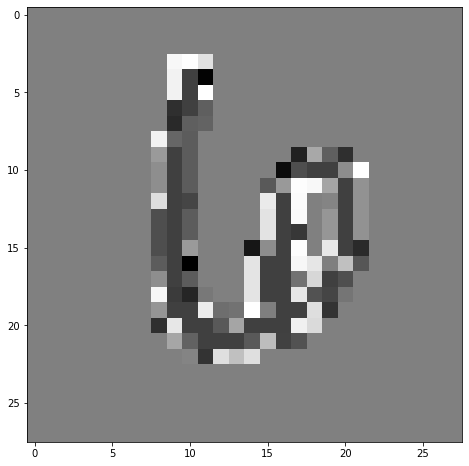

In [ ]:
predict(test_dataset)

###Visualizing feaure maps

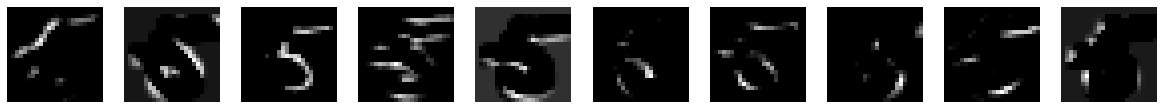

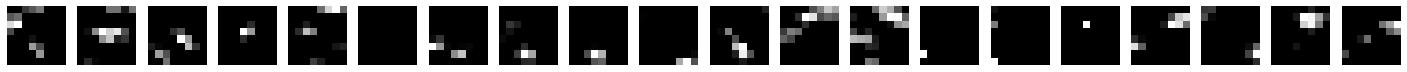

In [ ]:
plt.figure(figsize=(50, 50))

maps = activation_1[0].cpu()

for idx, map in enumerate(maps):
  plt.subplot(24, 24, 1 + idx)
  plt.imshow(map, cmap='gray')
  plt.axis("off")


plt.figure(figsize=(30, 50))

maps = activation_2[0].cpu()

for idx, map in enumerate(maps):
  plt.subplot(24, 24, 1 + idx)
  plt.imshow(map, cmap='gray')
  plt.axis("off")